In [ ]:
!pip install xgboost

In [ ]:
!pip install tsfresh

In [ ]:
import os
import os.path as op
from pathlib   import Path
from glob      import glob
from tqdm      import tqdm
from datetime  import datetime

import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from scipy.stats import skew
from scipy.stats import kurtosis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from xgboost import XGBClassifier
from tsfresh.feature_extraction import feature_calculators

Please upload train.json

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.json to test.json
Saving train.json to train.json


In [ ]:
with open('train.json', 'r') as f:
    track_data = json.load(f)
# How many tracks are there?
print(f"n_tracks = {len(track_data.keys())}")

# What do the track Unique IDs (UIDs) look like?
track_uids = list(track_data.keys())
print(f"5 Example Track IDs = {track_uids[:5]}")

# What fields are avaiable for each track?
example_uid = track_uids[0]
print(f"Per-track keys = {track_data[example_uid].keys()}")

# What do the (t, x, y) track coordinates look like?
example_coords = track_data[track_uids[5]]['txy']
example_coords = np.array(example_coords)
np.set_printoptions(threshold=10)
print(f"Coordinate array = \n{example_coords}")

# What does the label look like?
example_label = track_data[track_uids[0]]['label']
print(f"Label = {example_label}")

n_tracks = 16080
5 Example Track IDs = ['lab_0_0', 'lab_0_1', 'lab_0_2', 'lab_0_3', 'lab_0_4']
Per-track keys = dict_keys(['txy', 'label'])
Coordinate array = 
[[ 49.    229.582 332.15 ]
 [ 50.    228.415 329.317]
 [ 51.    227.249 326.483]
 ...
 [164.    308.458   8.42 ]
 [165.    310.583   5.545]
 [166.    312.708   2.67 ]]
Label = 0


# New Section

In [ ]:
def mean_step_speed(coords):
    """Mean step speed of the entire track.

    The average per-step speed. Basically the average of distances between points adjacent in time.

    Returns
    -------
    float
        The average step speed.
    """

    speeds = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]

        # Speed in pixels per frame
        curr_speed = np.linalg.norm(curr - prev)

        # Accumulate per-step speeds into a list
        speeds.append(curr_speed)

    # Return the average of the speeds
    return np.mean(speeds)


def stddev_step_speed(coords):
    """Standard deviation of the step speed of the entire track.

    The standard deviation of the per-step speed.

    Returns
    -------
    float
        The stddev of the step speed.
    """

    speeds = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]

        # Speed in pixels per frame
        curr_speed = np.linalg.norm(curr - prev)

        # Accumulate per-step speeds into a list
        speeds.append(curr_speed)

    # Return the standard deviation of the speeds
    return np.std(speeds)


def track_length(coords):
    """Standard deviation of the step speed of the entire track.

    The standard deviation of the per-step speed.

    Returns
    -------
    float
        The length of the entire track.
    """

    lengths = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1,1:]
        # Current coordinate location
        curr = coords[i,1:]

        # Speed in pixels per frame
        step_length = np.linalg.norm(curr - prev)

        # Accumulate per-step speeds into a list
        lengths.append(step_length)

    # Return the sum of the lengths
    return np.sum(lengths)


def e2e_distance(coords):
    """End-to-end distance of the track.

    The distance from the start and the end of the given track.

    Returns
    -------
    float
        The end-to-end distance of the entire track.
    """

    # Start and end of the track
    start = coords[0, 1:]
    end = coords[-1, 1:]

    # Return the distance
    return np.linalg.norm(end-start)


def duration(coords):
    """Duration of the track.

    The time duration of the track.

    Returns
    -------
    int
        The end-to-end duration of the entire track.
    """

    # Start and end times of the track
    start_t = coords[0, 0]
    end_t = coords[-1, 0]

    # Return the difference
    return end_t - start_t


######################################
# Implement your own features below! #
######################################

def linearity(coords):
  """ Quantifies how linear the track is by regressing y on x, and computing the error.

  Returns
  -------
  float
    Error on least squares regression of y on x.
  """

  x = coords[:, 1].reshape(-1, 1)
  y = coords[:, 2]
  model = LinearRegression().fit(x, y)
  r_sq = model.score(x, y)

  return r_sq


def skew_step_speed(coords):
    """Skew step speed of the entire track.

    """

    speeds = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]

        # Speed in pixels per frame
        curr_speed = np.linalg.norm(curr - prev)

        # Accumulate per-step speeds into a list
        speeds.append(curr_speed)

    # Return the average of the speeds
    return skew(speeds)


def kurt_step_speed(coords):
    """Kurtosis step speed of the entire track.

    """

    speeds = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]

        curr_speed = np.linalg.norm(curr - prev)
        speeds.append(curr_speed)

    return kurtosis(speeds)

def max_speed(coords):

  """
    Max speed

  """

  speeds = []

  for i in range(1, coords.shape[0]):
      # Previous coordinate location
      prev = coords[i-1, 1:]
      # Current coordinate location
      curr = coords[i, 1:]

      curr_speed = np.linalg.norm(curr - prev)

      speeds.append(curr_speed)
  if len(speeds) < 1:
    return 0

  return np.max(speeds)

def min_speed(coords):

  """
    Min speed

  """

  speeds = []

  for i in range(1, coords.shape[0]):
      # Previous coordinate location
      prev = coords[i-1, 1:]
      # Current coordinate location
      curr = coords[i, 1:]

      curr_speed = np.linalg.norm(curr - prev)

      speeds.append(curr_speed)
  if len(speeds) < 1:
    return 0

  return np.min(speeds)


def mean_accel(coords):
    """
    Returns
    -------
    float

    """

    speeds = []
    accel = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]

        curr_speed = np.linalg.norm(curr - prev)

        speeds.append(curr_speed)
        if i > 1:
          accel.append(speeds[i-1] - speeds [i-2])


    return np.mean(accel)



def std_dev_accel(coords):
    """

    Returns
    -------
    float

    """

    speeds = []
    accel = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]

        curr_speed = np.linalg.norm(curr - prev)

        speeds.append(curr_speed)
        if i > 1:
          accel.append(speeds[i-1] - speeds [i-2])


    return np.std(accel)

def cmplx_speed(coords):
    """

    Returns
    -------
    float

    """

    speeds = []
    accel = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]

        curr_speed = np.linalg.norm(curr - prev)

        speeds.append(curr_speed)


    return feature_calculators.cid_ce(speeds, True)


def cmplx_x(coords):
    """

    Returns
    -------
    float

    """

    x = coords[:, 1]

    return feature_calculators.cid_ce(x, True)

def cmplx_y(coords):
    """

    Returns
    -------
    float

    """

    y = coords[:, 2]


    return feature_calculators.cid_ce(y, True)

In [ ]:
from sklearn.metrics.cluster import entropy


FEATURE_LIST = [mean_step_speed, stddev_step_speed, track_length, e2e_distance, duration, linearity, skew_step_speed,
                kurt_step_speed, max_speed, min_speed, mean_accel, std_dev_accel, cmplx_speed, cmplx_x, cmplx_y]
TYPE = "train"
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
# OUTPUT_FILENAME = f"{TYPE}_features_{TIMESTAMP}.csv"
OUTPUT_FILENAME = f"{TYPE}.csv"

# Generate the feature csv
header = ['uid', 'label']
for featfunc in FEATURE_LIST:
    header.append(featfunc.__name__)

features = []

track_uids = track_data.keys()
for uid in track_uids:
    curr_row = {
        'uid': uid,
        'label': track_data[uid]['label']
    }

    for featfunc in FEATURE_LIST:
        curr_row[featfunc.__name__] = featfunc(np.array(track_data[uid]['txy']))

    features.append(curr_row)

with open(OUTPUT_FILENAME, 'w') as f:
    writer = csv.DictWriter(f, fieldnames = header)
    writer.writeheader()
    for r in features:
        writer.writerow(r)

print("Written to:", OUTPUT_FILENAME)

In [ ]:
df = pd.read_csv('train.csv')
df['rsd'] = (df['stddev_step_speed']) / (df['mean_step_speed']+0.001)


df_lab = df[df['uid'].str.contains("lab")]
df_sim = df[df['uid'].str.contains("sim")]


In [ ]:
df = pd.read_csv('train.csv')

from matplotlib.pyplot import figure

figure(figsize=(3.5, 3), dpi=200)
sns.scatterplot(data=df.sample(n=1000), x='mean_step_speed',  y='mean_step_speed', hue='label')

In [ ]:
figure(figsize=(3.5, 3), dpi=200)
sns.scatterplot(data=dfplots.sample(n=1000), x='linearity',  y='linearity', hue='label')

XGB

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
f2 = []


xgbc = XGBClassifier(

    subsample=1,
    colsample_bytree=0.5,
    min_child_weight=5,
    max_depth=6,
    learning_rate=0.03,
    n_estimators=100)

train = df_lab.append(df_sim.sample(n=15000)).dropna()
test = df_lab.tail(100).dropna()

X_train = train.drop(['label', 'uid'], axis=1)
X_test = test.drop(['label', 'uid'], axis=1)

y_train = train['label']
y_test = test['label']
xgbc.fit(X_train, y_train)

scores = cross_val_score(xgbc, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbc, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

y_pred = xgbc.predict(X_test)
f2.append(metrics.fbeta_score(y_test, y_pred, beta=2, average='binary'))
print(np.mean(f2))

LGBM


In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb

In [ ]:
f2=[]
lgbc = lgb.LGBMClassifier(learning_rate=0.1,max_depth=20,
      subsample=0.5,
      colsample_bytree=0.5,
      min_child_weight=1,
      n_estimators=300)

train = df_lab.tail(100).append(df_sim.sample(n=100)).dropna()
test = df_lab.head(250).dropna()

X_train = train.drop(['label', 'uid'], axis=1)
X_test = test.drop(['label', 'uid'], axis=1)

y_train = train['label']
y_test = test['label']

scores = cross_val_score(xgbc, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbc, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

lgbc.fit(X_train, y_train)
y_pred = lgbc.predict(X_test)
f2.append(metrics.fbeta_score(y_test, y_pred, beta=2, average='binary'))
print(lgbc.score(X_test, y_test))


0.8518034481701898


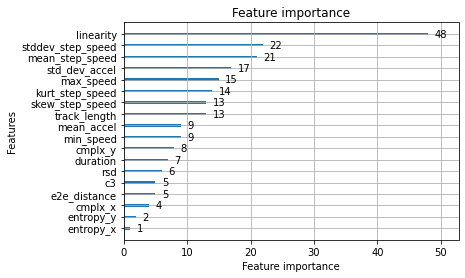

In [ ]:
lgb.plot_importance(lgbc)

In [ ]:
from sklearn.model_selection import GridSearchCV
PARAMETERS = {"subsample":[0.5, 0.75, 1],
"colsample_bytree":[0.5, 0.75, 1],
"max_depth":[2, 6, 12],
"min_child_weight":[1,5,15],
"learning_rate":[0.3, 0.1, 0.03],
"n_estimators":[100]}

eval_set = [(X_train, y_train),(X_test,y_test)]
#Initialise XGBoost Model
#model = XGBClassifier(n_estimators=100, n_jobs=-1)
model = lgb.LGBMClassifier(learning_rate=0.03,max_depth=-5)
model_gs = GridSearchCV(model,param_grid=PARAMETERS,cv=3,scoring="accuracy")
#Fit the model as done previously
model_gs.fit(X_train,y_train,early_stopping_rounds=10, eval_metric="error",eval_set=eval_set,verbose=0)
print(model_gs.best_params_)

{'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.5}


Random Forest

In [ ]:

f2 = []

train = df_lab.append(df_sim.sample(n=15000)).dropna()
test = df_lab.tail(200).dropna()


clf = RandomForestClassifier(n_estimators = 100)

X_train = train.drop(['label', 'uid'], axis=1)
X_test = test.drop(['label', 'uid'], axis=1)

X_train = train.drop(['label', 'uid', 'rwalk_x', 'rwalk_y'], axis=1)
X_test = test.drop(['label', 'uid', 'rwalk_x', 'rwalk_y'], axis=1)

y_train = train['label']
y_test = test['label']

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cv = cross_validate(clf, df_lab.drop(['label', 'uid'], axis=1), df_lab['label'], cv=5)

print("f2 score: ", metrics.fbeta_score(y_test, y_pred, beta=2, average='binary'))
f2.append(metrics.fbeta_score(y_test, y_pred, beta=2, average='binary'))



Running the code with test.json will generate test.csv

In [ ]:
df_test = pd.read_csv('test.csv')
df_test['rsd'] = (df_test['stddev_step_speed']) / (df_test['mean_step_speed']+0.001)


In [ ]:
y_pred_test_lgb = lgbc.predict(df_test.drop(['label', 'uid'], axis=1))
df_test['label'] = y_pred_test_lgb
test = df_test[['uid', 'label']]
test.to_csv('testlgb.csv', index=False)